# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 6</span>


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import seaborn as sns
import scipy

colors = sns.color_palette("hls", 8)   # Colors
title_size = 16                        # Size title
axis_size = 14                         # Size axis label
value_size = 10                        # Size values on axis
legend_size = 12                       # Size legend


In Statistical Mechanics the one-dimensional (1D) Ising Model is exactly resoluble. The Hamiltonian for a system of N spins with nearest neighbors interaction is given by (in the following I will assume units such that $\mu_B=1$ and $k_B=1$):

$$
H = 
-J\sum_{i=1}^N s_i s_{i+1}
-\frac{h}{2}\sum_{i=1}^N (s_i + s_{i+1}) 
$$

where $\{ s_i \}_{i=1,N}$ are spin variables taking values in $\{-1;1\}$, $J>0$ (ferromagnetic model),and with the assumption $s_{N+1} = s_{1}$.

The partition function for $N$ spins, $Z$, can be exactly computed and it turns out to be:

$$
Z=\sum_{\{ s_i \}} \exp \left( -\beta H\right) = \lambda_1^N + \lambda_2^N
$$

where
$\lambda_{1,2} = 
e^{\beta J} 
\cosh (\beta h) \pm \left[ e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J) \right]^{1/2}$, 
and where $\beta=\frac{1}{k_b T} = \frac{1}{T}$.
Once the partition function has been computed, the Helmholtz free energy is readly obtained as $A = -k_B T \ln Z$. All the thermodynamic quantities of interest can be deduced from $A$ or, equivalently, from $Z$.

## Exercise 06.1
### Assignment

Complete the NSL_simulator code to simulate a 1D Ising model with the Gibbs sampling algorithm (the Metropolis algorithm is already implemented) to sample the Boltzmann's weight $p(\{ s_i \}) = \exp(-\beta H)/Z$. Verify the possibility to restart from a previous spin configuration.

The code already computes the internal energy: $U(N,T) = \langle H \rangle$. Add the calculation of $C(N,T)$, $\chi(N,T)$, $M(N,T,h)$ and compute:
1. $U(N,T) = \langle H \rangle_{h=0}$
2. $C(N,T) = k_B \beta^2 (\langle H^2 \rangle_{h=0}-\langle H \rangle_{h=0}^2)$ 
3. $\chi(N,T) = \beta \langle (\sum_{i=1,N}s_i)^2 \rangle_{h=0}$
4. $M(N,T,h=0.02)= \langle \sum_{i=1,N}s_i \rangle_{h=0.02}$

as a function of $T$ in the range $\left[0.5;2.0\right]$ for a system of $N=50$ spins with $J=1$.

As usual, use data blocking and give an estimate of the statistical uncertainties.

- Show pictures of your estimations of $U(N,T)$, $C(N,T)$, $\chi(N,T)$, $M(N,T,h=0.02)$ and their uncertainties obtained with a large number of *MC steps* (e.g. $M\ge 10^5$) compared with the exact curves. In the same picture show your results obtained with both sampling methods, Metropolis and Gibbs.

A Monte Carlo step will consist in trying to flip one time all the spins of the system. Do not forget to equilibrate your simulations and to use blocking average with blocks large enough.

### Resolution

The Metropolis and Gibbs sampling algorithms allow generating random spin configurations in a 1D Ising system at a fixed temperature.

The **Metropolis algorithm** for the Ising model consists of choosing a particle and proposing a spin flip (state $x \to$ state $y$). The acceptance probability is given by:

$$ A(y|x) = min \left[1, \frac{T(x|y)p(y)}{T(y|x)p(x)}\right] = min \left[1, \frac{p(y)}{p(x)}\right] = min \left[1, e^{-\beta \Delta E}\right] $$

where $\Delta E = E_y - E_x$ is the different of energy between the new state and the old one.

The **Gibbs algorithm** for the Ising model consists of choosing a random particle and proposing a new spin value independently from the original one. The acceptance probability is defined by the neighboring spins:

$$ p(s_i' = \pm 1 | \{s_j\}_{j \neq i}) = \frac{1}{1 + e^{-\beta \Delta E_{s_i=\mp 1 \to s_i'=\pm 1}}}$$

where $\Delta E_{s_i=\mp 1 \to s_i'=\pm 1} = 2J\sum_{j (n.n. to i)}s_j$ is the variation of energy due to the interaction between the chosen spin and its neighboring spins.

The Metropolis algortihm is already implemented in the code.
I implemented the Gibbs' algorithms within the `void System ::move()` function:

```cpp
if (_sim_type == 3) // Gibbs sampler for Ising
{
	double delta_E_plus = 2. * (_J * (double(_particle(this->pbc(i - 1)).getspin()) + double(_particle(this->pbc(i + 1)).getspin())) + _H);
	double prob_plus = 1. / (1. + exp(-_beta * delta_E_plus));

	if(_rnd.Rannyu() <= prob_plus)
		_particle(i).setspin(1);
	else
		_particle(i).setspin(-1);
  	_naccepted++;
} 
```

I add the implementation for the physical quantities within `void System ::move()` function:

```cpp
// ... //
// Sum spin of system
if (_measure_chi or _measure_magnet) 
{
	for (int i = 0; i < _npart; i++)
      sum_spin += double(_particle(i).getspin());
}
// ... //
// MAGNETIZATION /////////////////////////////////////////////////////////////
  if (_measure_magnet)
    _measurement(_index_magnet) = sum_spin;
// SPECIFIC HEAT /////////////////////////////////////////////////////////////
if (_measure_cv and _measure_tenergy)
	_measurement(_index_cv) = pow(_measurement(_index_tenergy), 2);

// SUSCEPTIBILITY ////////////////////////////////////////////////////////////
if (_measure_chi)
    _measurement(_index_chi) = _beta * pow(sum_spin, 2);
```
For the heat capacity, which requires the mean energy, I implemented the given formula in the `void System::averages()` function:

```cpp
// ... //
// Calculate specific heat
if (_measure_cv and _measure_tenergy)
	_average(_index_cv) = pow(_beta, 2) * (_average(_index_cv) - pow(_average(_index_tenergy), 2));
// ... //
```
I studied the behavior of the spin system in the temperature interval $T = [0.5, 2]$ with an increment of 0.01 using a `for` loop. Within the loop, I initialized the system with the updated temperature. For each temperature, I equilibrated the system and used data blocking with $N_{blocks} = 20$ and $N_{steps} = 50000$. I printed the means and uncertainties of the quantities studied of the last block at each temperature in a single file `Ising.dat`.

All the quantities obtained with the two sampling methods are almost always compatible with the expected values. There are major discrepancies in the interval $T = [0.5, 0.9]$, probably because the Boltzmann weight at these low temperatures is very small, causing the trial moves to be frequently rejected and preventing adequate exploration of the phase space. Anyway, the Metropolis algorithm seems to be more precise than Gibbs one.

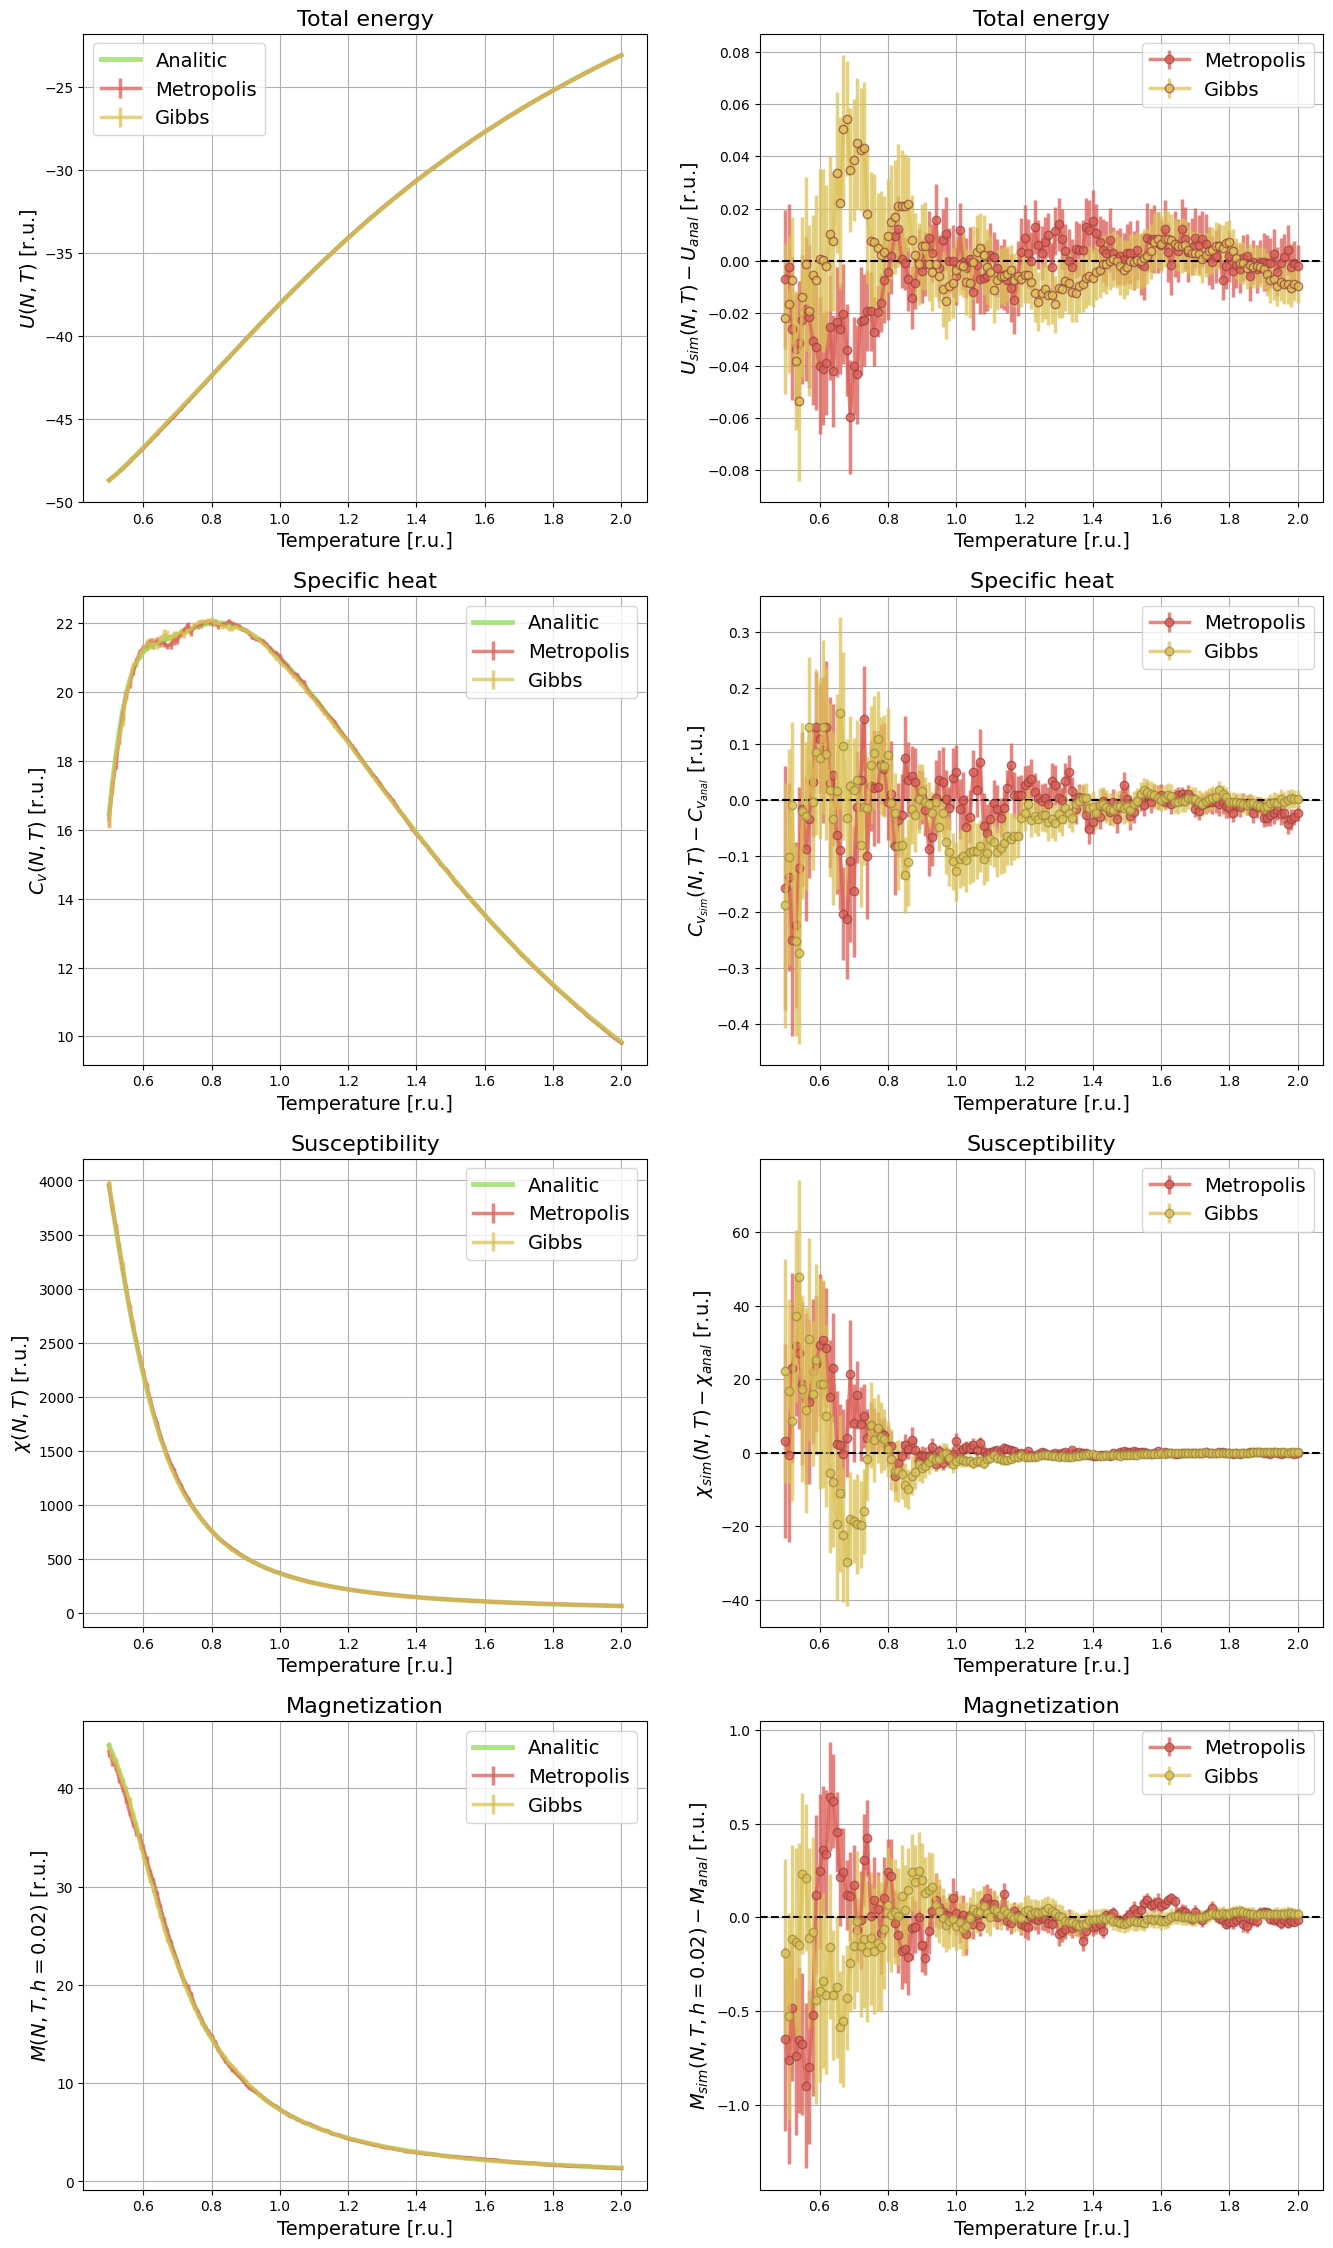

In [17]:
# Data import
df_M = pd.read_csv('../E06/OUTPUT/Metropolis/Ising.dat', delimiter=' ', index_col=False)
df_M_2 = pd.read_csv('../E06/OUTPUT/Metropolis_H/Ising.dat', delimiter=' ', index_col=False)
df_G = pd.read_csv('../E06/OUTPUT/Gibbs/Ising.dat', delimiter=' ', index_col=False)
df_G_2 = pd.read_csv('../E06/OUTPUT/Gibbs_H/Ising.dat', delimiter=' ', index_col=False)

# Data
step = 0.01
T = np.arange(0.5, 2. + step, step)
beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th
e = - Ns * J*( th + ch*thN )/( 1 + thN ) #Internal energy
heat= Ns * ((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2) #Heat capacity
X = Ns *beta*np.exp(2*beta*J)*(1-thN)/(1+thN) #Susceptibility
h=0.02 #external field
b = 1/T
l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
Z = l1**Ns + l2**Ns
M = Ns * (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
        + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z) # Magnetization

#Plot total energy
plt.figure(figsize=(16, 28))
plt.subplot(4, 2, 1)
plt.errorbar(df_M['T'], df_M['U'], yerr = df_M['Err_U'], color = colors[0], linewidth=2.5, alpha=0.75, label="Metropolis")
plt.errorbar(df_G['T'], df_G['U'], yerr = df_G['Err_U'], color = colors[1], linewidth=2.5, alpha=0.75, label="Gibbs")
plt.plot(T, e, color = colors[2], linewidth=3.5, alpha=0.75, label="Analitic")
plt.title("Total energy", fontsize=title_size)
plt.xlabel(r'Temperature [r.u.]', fontsize=axis_size)
plt.ylabel(r'$U(N, T)$ [r.u.]', fontsize=axis_size)
plt.tick_params(axis='both', which='major', labelsize=value_size)
plt.legend(fontsize=axis_size)
plt.grid(True)

plt.subplot(4, 2, 2)
plt.errorbar(df_M['T'], df_M['U'] - e, yerr = df_M['Err_U'], color = colors[0], linewidth=2.5, alpha=0.75,  marker='o', mec=tuple(np.array(colors[0]) * 0.7), label="Metropolis")
plt.errorbar(df_G['T'], df_G['U'] - e, yerr = df_G['Err_U'], color = colors[1], linewidth=2.5, alpha=0.75,  marker='o', mec=tuple(np.array(colors[0]) * 0.7), label="Gibbs")
plt.axhline(y=0, color = 'black', linestyle='--', linewidth = 1.5)
plt.title("Total energy", fontsize=title_size)
plt.xlabel(r'Temperature [r.u.]', fontsize=axis_size)
plt.ylabel(r'$U_{sim}(N, T) - U_{anal}$ [r.u.]', fontsize=axis_size)
plt.tick_params(axis='both', which='major', labelsize=value_size)
plt.legend(fontsize=axis_size)
plt.grid(True)

#Plot specific heat
plt.subplot(4, 2, 3)
plt.errorbar(df_M['T'], df_M['Cv'], yerr = df_M['Err_Cv'], color = colors[0], linewidth=2.5, alpha=0.75, label="Metropolis")
plt.errorbar(df_G['T'], df_G['Cv'], yerr = df_G['Err_Cv'], color = colors[1], linewidth=2.5, alpha=0.75, label="Gibbs")
plt.plot(T, heat, color = colors[2], linewidth=3.5, alpha=0.75, label="Analitic")
plt.title("Specific heat", fontsize=title_size)
plt.xlabel(r'Temperature [r.u.]', fontsize=axis_size)
plt.ylabel(r'$C_v(N, T)$ [r.u.]', fontsize=axis_size)
plt.tick_params(axis='both', which='major', labelsize=value_size)
plt.legend(fontsize=axis_size)
plt.grid(True)

plt.subplot(4, 2, 4)
plt.errorbar(df_M['T'], df_M['Cv'] - heat, yerr = df_M['Err_Cv'], color = colors[0], linewidth=2.5, alpha=0.75, marker='o', mec=tuple(np.array(colors[0]) * 0.7), label="Metropolis")
plt.errorbar(df_G['T'], df_G['Cv'] - heat, yerr = df_G['Err_Cv'], color = colors[1], linewidth=2.5, alpha=0.75, marker='o', mec=tuple(np.array(colors[1]) * 0.7), label="Gibbs")
plt.axhline(y=0, color = 'black', linestyle='--', linewidth = 1.5)
plt.title("Specific heat", fontsize=title_size)
plt.xlabel(r'Temperature [r.u.]', fontsize=axis_size)
plt.ylabel(r'$C_{v_{sim}}(N, T) - C_{v_{anal}}$ [r.u.]', fontsize=axis_size)
plt.tick_params(axis='both', which='major', labelsize=value_size)
plt.legend(fontsize=axis_size)
plt.grid(True)

#Plot susceptibility
plt.subplot(4, 2, 5)
plt.errorbar(df_M['T'], df_M['X'], yerr = df_M['Err_X'], color = colors[0], linewidth=2.5, alpha=0.75, label="Metropolis")
plt.errorbar(df_G['T'], df_G['X'], yerr = df_G['Err_X'], color = colors[1], linewidth=2.5, alpha=0.75, label="Gibbs")
plt.plot(T, X, color = colors[2], linewidth=3.5, alpha=0.75, label="Analitic")
plt.title("Susceptibility", fontsize=title_size)
plt.xlabel(r'Temperature [r.u.]', fontsize=axis_size)
plt.ylabel(r'$\chi(N, T)$ [r.u.]', fontsize=axis_size)
plt.tick_params(axis='both', which='major', labelsize=value_size)
plt.legend(fontsize=axis_size)
plt.grid(True)

plt.subplot(4, 2, 6)
plt.errorbar(df_M['T'], df_M['X'] - X, yerr = df_M['Err_X'], color = colors[0], linewidth=2.5, alpha=0.75, marker='o', mec=tuple(np.array(colors[0]) * 0.7), label="Metropolis")
plt.errorbar(df_G['T'], df_G['X'] - X, yerr = df_G['Err_X'], color = colors[1], linewidth=2.5, alpha=0.75, marker='o', mec=tuple(np.array(colors[1]) * 0.7), label="Gibbs")
plt.axhline(y=0, color = 'black', linestyle='--', linewidth = 1.5)
plt.title("Susceptibility", fontsize=title_size)
plt.xlabel(r'Temperature [r.u.]', fontsize=axis_size)
plt.ylabel(r'$\chi_{sim}(N, T) - \chi_{anal}$ [r.u.]', fontsize=axis_size)
plt.tick_params(axis='both', which='major', labelsize=value_size)
plt.legend(fontsize=axis_size)
plt.grid(True)

#Plot magnetization
plt.subplot(4, 2, 7)
plt.errorbar(df_M_2['T'], df_M_2['M'], yerr = df_M_2['Err_M'], color = colors[0], linewidth=2.5, alpha=0.75, label="Metropolis")
plt.errorbar(df_G_2['T'], df_G_2['M'], yerr = df_G_2['Err_M'], color = colors[1], linewidth=2.5, alpha=0.75, label="Gibbs")
plt.plot(T, M, color = colors[2], linewidth=3.5, alpha=0.75, label="Analitic")
plt.title("Magnetization", fontsize=title_size)
plt.xlabel(r'Temperature [r.u.]', fontsize=axis_size)
plt.ylabel(r'$M(N, T, h=0.02)$ [r.u.]', fontsize=axis_size)
plt.tick_params(axis='both', which='major', labelsize=value_size)
plt.legend(fontsize=axis_size)
plt.grid(True)

plt.subplot(4, 2, 8)
plt.errorbar(df_M_2['T'], df_M_2['M'] - M, yerr = df_M_2['Err_M'], color = colors[0], linewidth=2.5, alpha=0.75, marker='o', mec=tuple(np.array(colors[0]) * 0.7), label="Metropolis")
plt.errorbar(df_G_2['T'], df_G_2['M'] - M, yerr = df_G_2['Err_M'], color = colors[1], linewidth=2.5, alpha=0.75, marker='o', mec=tuple(np.array(colors[1]) * 0.7), label="Gibbs")
plt.axhline(y=0, color = 'black', linestyle='--', linewidth = 1.5)
plt.title("Magnetization", fontsize=title_size)
plt.xlabel(r'Temperature [r.u.]', fontsize=axis_size)
plt.ylabel(r'$M_{sim}(N, T, h=0.02) - M_{anal}$ [r.u.]', fontsize=axis_size)
plt.tick_params(axis='both', which='major', labelsize=value_size)
plt.legend(fontsize=axis_size)
plt.grid(True)